In [1]:
import sys, os
sys.path.insert(0, '../..')
from project_utils import *

In [28]:
# EXAMPLE:
# from nilearn import datasets
# development_dataset = datasets.fetch_development_fmri(n_subjects=10)

# from nilearn.maskers import NiftiMapsMasker
# msdl_data = datasets.fetch_atlas_msdl()
# msdl_coords = msdl_data.region_coords
# n_regions = len(msdl_coords)
# print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
#     n_regions, msdl_data.networks))
# masker = NiftiMapsMasker(
#     msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
#     low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

# children = []
# pooled_subjects = []
# groups = []  # child or adult
# for func_file, confound_file, phenotypic in zip(
#         development_dataset.func,
#         development_dataset.confounds,
#         development_dataset.phenotypic):
#     time_series = masker.transform(func_file, confounds=confound_file)
#     pooled_subjects.append(time_series)
#     if phenotypic['Child_Adult'] == 'child':
#         children.append(time_series)
#     groups.append(phenotypic['Child_Adult'])

# pooled_subjects[0].shape

## Compare correlation, partial correlation, tangent for classification

In [5]:
# get files
ts_fnames = glob.glob(f'{ts_dir}/*.xlsx')
sub_info  = get_fname_ids(ts_fnames)
fnames    = list(sub_info['fname'])

# get roi labels
ts = read_excel(fnames[0], index_col='roi')
atlas = 'HO'
atlas_labels = [f for f in ts.index if atlas in f] 
display(ts.head(3))

# get data
y = (sub_info['dx'] == 'HC').values * 1
X = [read_excel(fname, index_col='roi').values.T for fname in fnames] # list of arrays w/ shape = (timepoints, rois)
X = np.asarray(X) # (sub, timepoints, rois)
print(f'X has shape: {X.shape}')

,trial_01,trial_02,trial_03,trial_04,trial_05,trial_06,trial_07,trial_08,trial_09,trial_10,...,trial_54,trial_55,trial_56,trial_57,trial_58,trial_59,trial_60,trial_61,trial_62,trial_63
roi,,,,,,,,,,,,,,,,,,,,,
HO_Cortl_LeftFrontalPole,1.977690,-0.411707,-1.173835,2.962344,-1.979488,-0.057670,-0.039260,5.228686,7.424488,4.998500,...,1.743220,3.423439,13.073288,-5.069925,-4.193394,-3.729652,-4.542775,-0.978760,-0.579640,-6.281849
HO_Cortl_RightFrontalPole,0.252821,-1.217320,1.118259,0.245231,-2.433977,-2.098905,-4.774854,-0.555683,3.104417,2.081878,...,2.105880,7.875526,9.871083,1.735422,-3.374624,-3.712898,-5.496897,2.809430,-7.014401,-6.113895
HO_Cortl_LeftInsularCortex,-0.466665,-0.014842,-0.948301,-1.243383,-0.073649,-1.598688,-1.685842,-1.046969,-0.280643,-1.952098,...,-0.790338,1.992695,1.301743,2.933826,0.702727,-1.528791,0.142945,-2.152604,1.262951,3.689466


In [ ]:
kinds = ['correlation', 'partial correlation', 'tangent']
cv = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=5)
scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(X, y):
        
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = nil.connectome.ConnectivityMeasure(kind=kind, vectorize=True)
        
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(X[train])
        
        # fit the classifier (just a linear svc here...)
        classifier = LinearSVC().fit(connectomes, y[train])
        
        # make predictions for the left-out test subjects
        predictions = classifier.predict(connectivity.transform(X[test]))
        
        # store the accuracy for this cross-validation fold
        scores[kind].append(sk.metrics.accuracy_score(y[test], predictions))

mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std  = [np.std(scores[kind]) for kind in kinds]

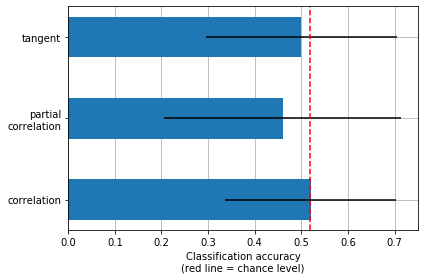

In [37]:
plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(1-np.mean(y), color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()